In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

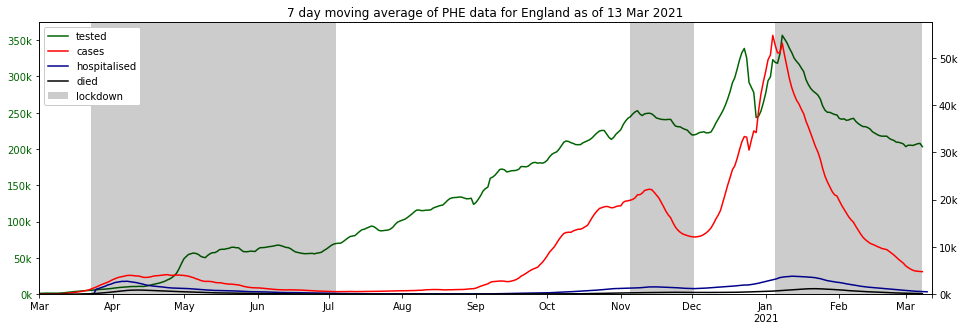

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum,),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

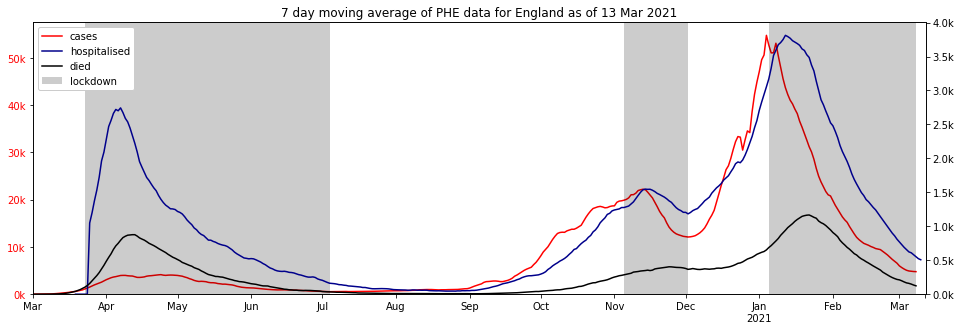

In [3]:
plot_summary(left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,1076426.0,20111189.0,19034763.0,56286961,1.912390,33.817358,64.270253
1,Northern Ireland,N92000002,50052.0,621462.0,571410.0,1893667,2.643126,30.174788,67.182086
2,Scotland,S92000003,156250.0,1867123.0,1710873.0,5463300,2.859993,31.315743,65.824264
3,Wales,W92000004,250026.0,1084329.0,834303.0,3152879,7.930085,26.461624,65.608290


'partial: 23,684,103 (35.5%), full: 1,532,754'

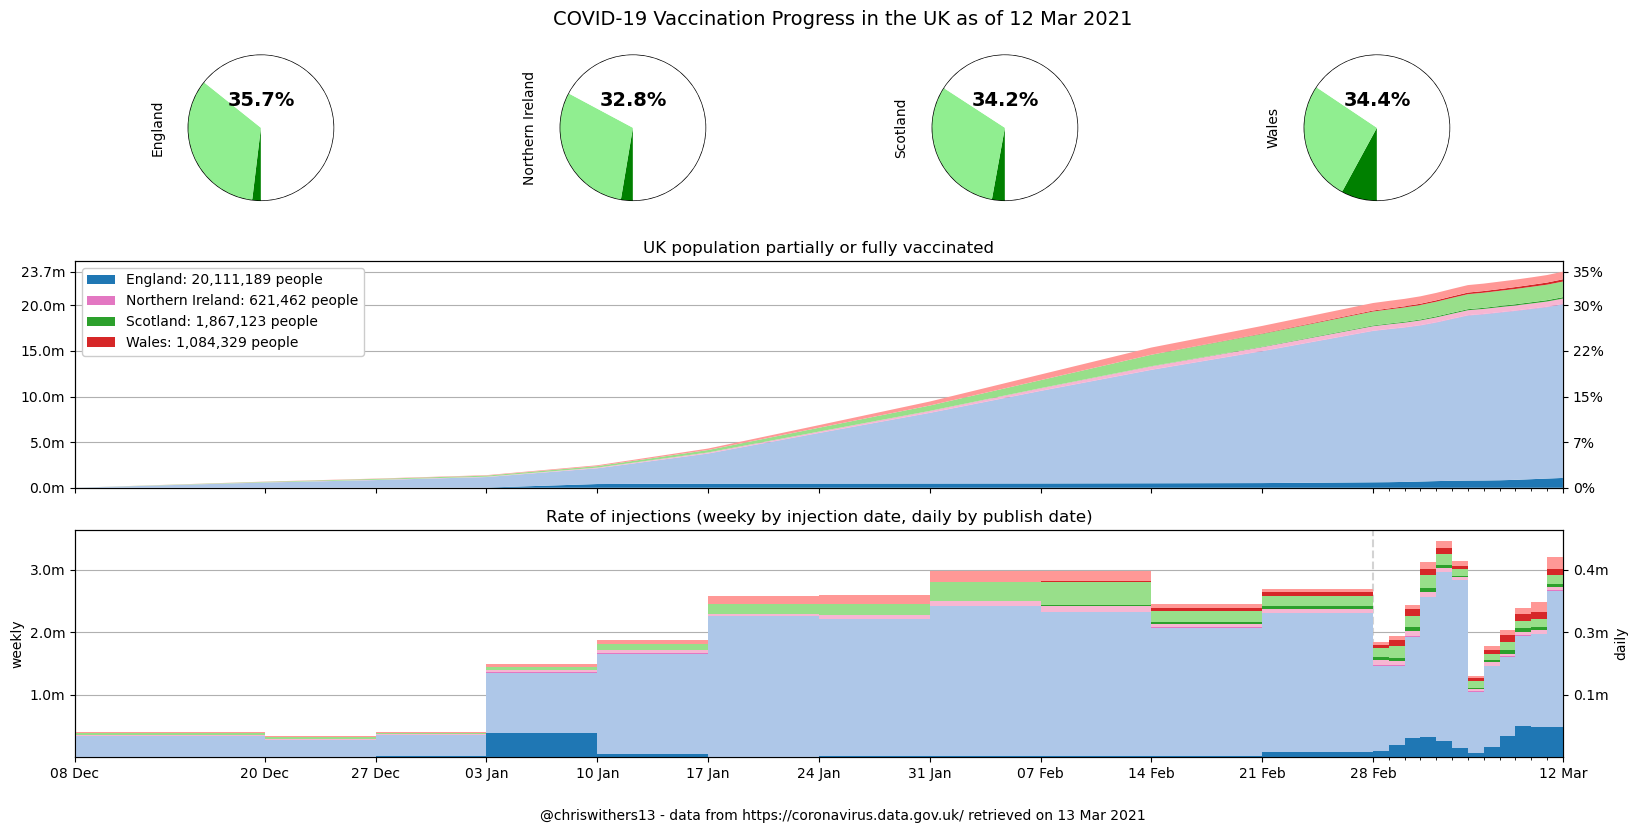

In [4]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [5]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,12 Mar 21,"+312,716","+67,514","+67,514","+20,111,189","+1,076,426","+1,076,426"
Northern Ireland,12 Mar 21,"+6,833",+652,+652,"+621,462","+50,052","+50,052"
Scotland,12 Mar 21,"+22,487","+6,841","+6,841","+1,867,123","+156,250","+156,250"
Wales,12 Mar 21,"+27,542","+12,669","+12,669","+1,084,329","+250,026","+250,026"


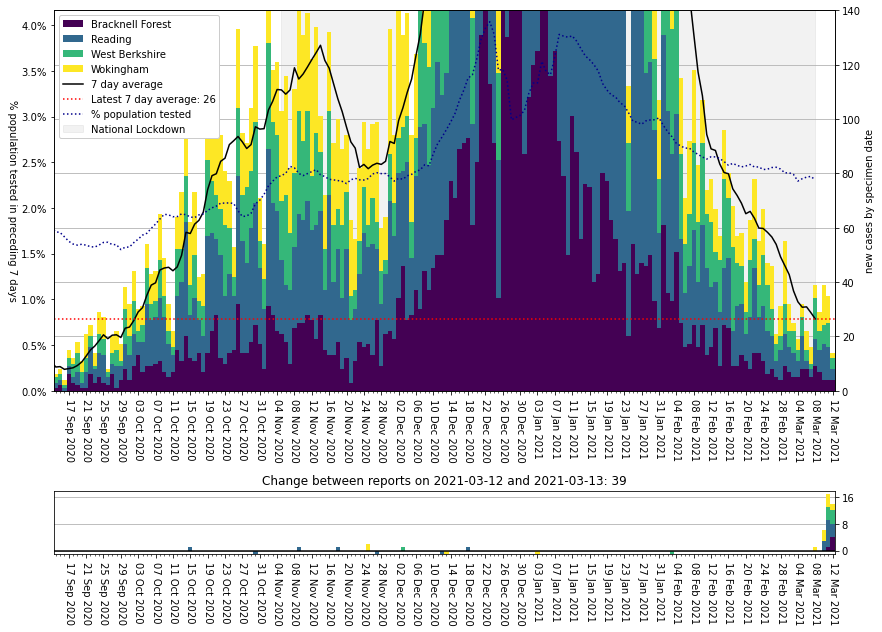

In [6]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=140)

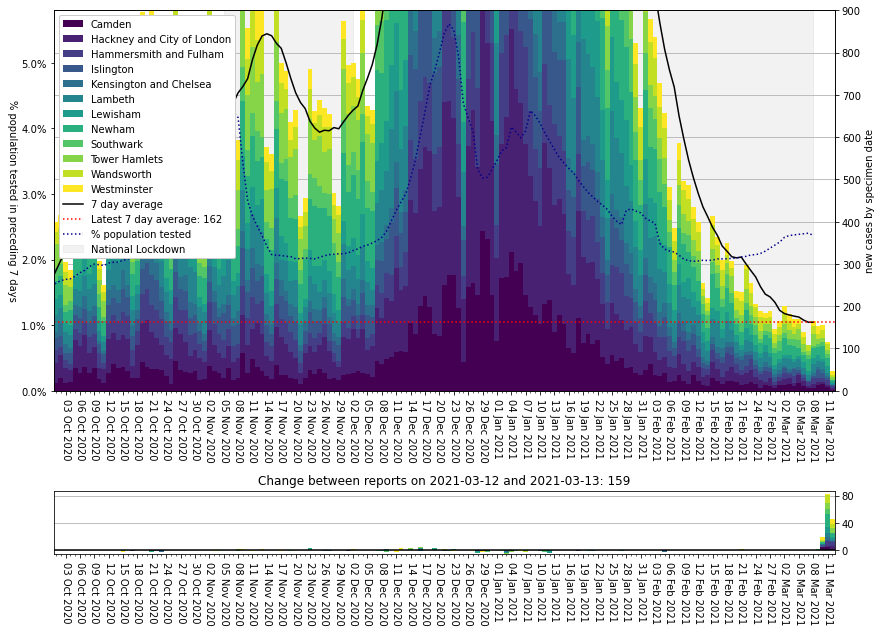

In [7]:
plot_areas(for_date, areas=london_areas, ylim=900)

In [8]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [9]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000150,Corby,160.624775,116.0,2021-03-12
E07000236,Redditch,146.608649,125.0,2021-03-12
E06000010,"Kingston upon Hull, City of",143.969081,374.0,2021-03-12
S12000030,Stirling,135.866681,128.0,2021-03-12
E08000016,Barnsley,134.485915,332.0,2021-03-12
E06000012,North East Lincolnshire,129.729323,207.0,2021-03-12
E08000032,Bradford,126.904494,685.0,2021-03-12
W06000024,Merthyr Tydfil,122.666843,74.0,2021-03-11
E07000123,Preston,120.166277,172.0,2021-03-12


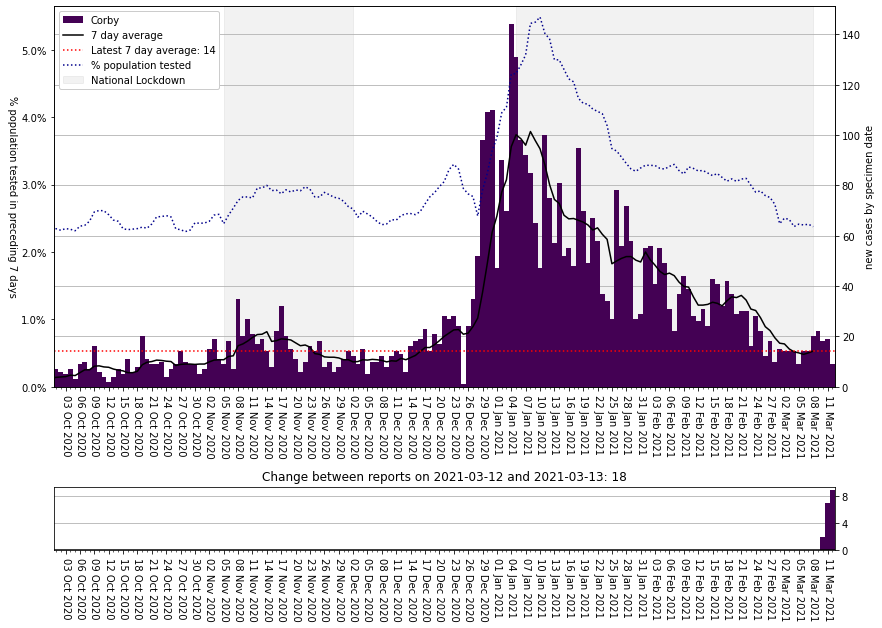

In [10]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [11]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,69.363190,792.0,2021-03-12
S12000049,Glasgow City,116.565580,738.0,2021-03-12
E08000035,Leeds,90.526377,718.0,2021-03-12
E08000032,Bradford,126.904494,685.0,2021-03-12
E08000019,Sheffield,79.678141,466.0,2021-03-12
E08000003,Manchester,80.309953,444.0,2021-03-12
E08000036,Wakefield,115.700866,403.0,2021-03-12
E08000034,Kirklees,90.498355,398.0,2021-03-12
S12000050,North Lanarkshire,114.831415,392.0,2021-03-12


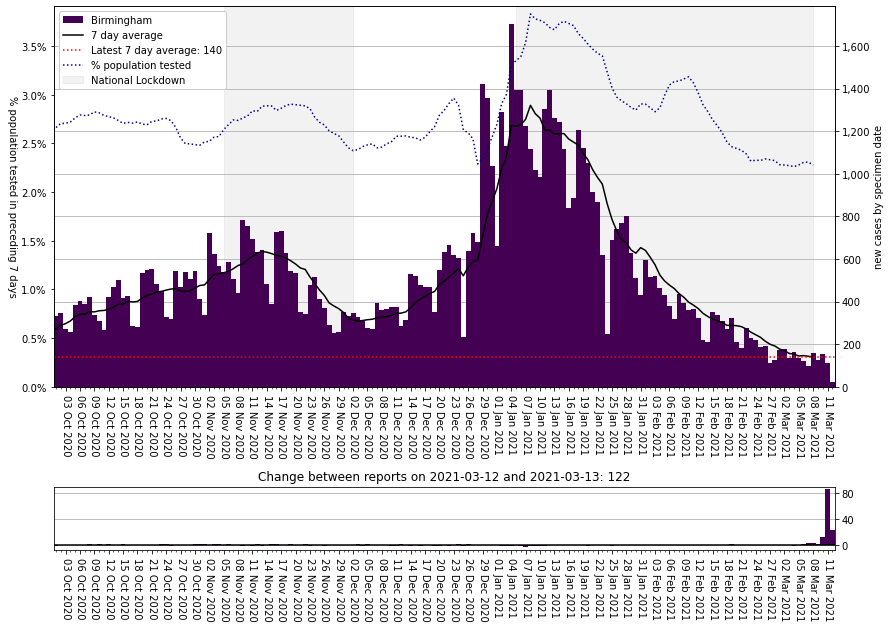

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.5
phe_max = 0.2

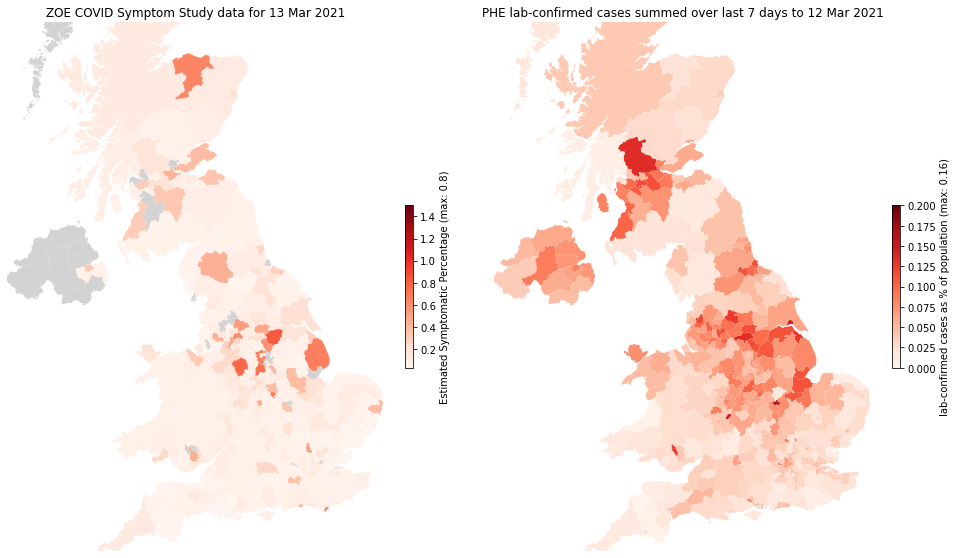

In [14]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [15]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

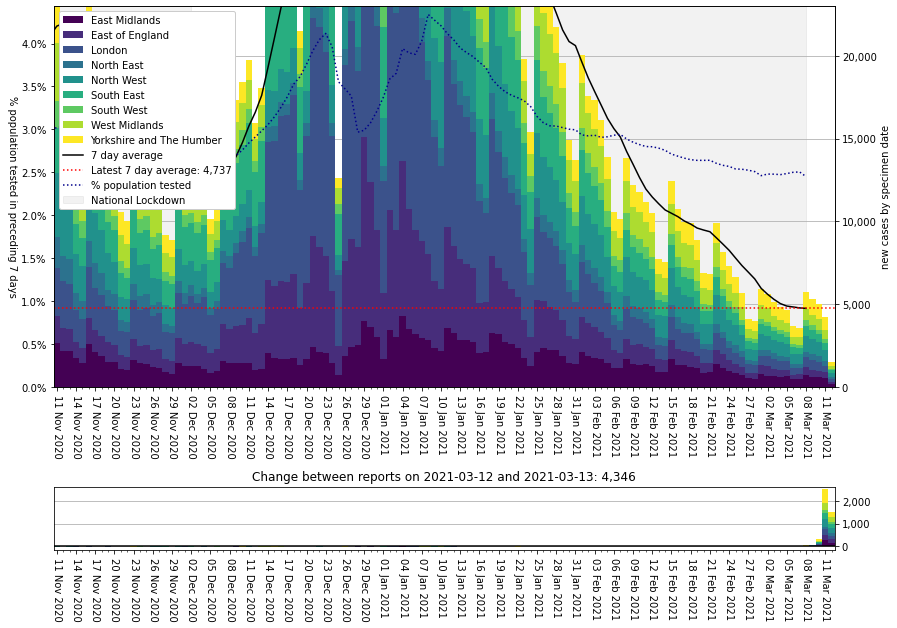

In [16]:
plot_areas(for_date, area_type=region, ylim=23_000, earliest='2020-11-11')

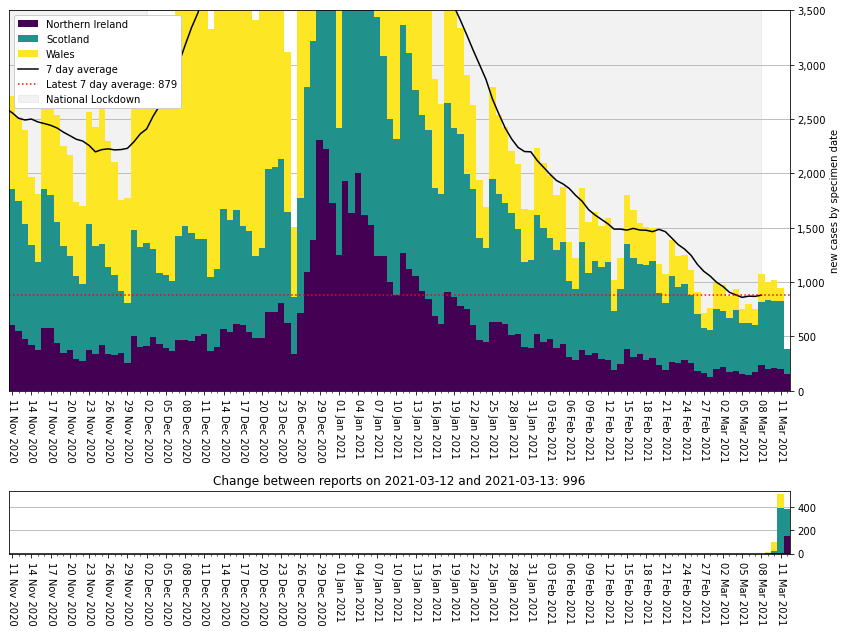

In [17]:
plot_areas(for_date, 'cases_devolved', ylim=3_500, diff_ylims=None, earliest='2020-11-11')